In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from pillow_heif import register_heif_opener
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
import pandas as pd

In [2]:
import pandas as pd
df=pd.read_csv('plant_spectro_image_processed.csv')

In [3]:
# ========== STEP 1: Preprocess Spectral Data ==========
spectral_data = df.iloc[:, 3:21].values
scaler = StandardScaler()
spectral_data_scaled = scaler.fit_transform(spectral_data)

In [4]:
register_heif_opener()

IMG_SIZE = (128, 128)
image_data = []
valid_indices = []

for i, row in df.iterrows():
    image_path = os.path.join("RAW", "imgs", row['folder'].strip('/'), row['image_name'])

    try:
        img = load_img(image_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        # Skipping image and not adding to dataset


In [5]:
# ========== STEP 3: Filter Data Based on Valid Images ==========
image_data = np.array(image_data)
spectral_data = spectral_data_scaled[valid_indices]
labels = df['class'].values[valid_indices]
labels = LabelEncoder().fit_transform(labels)

In [6]:
# ========== STEP 4: Split ==========
X_img_train, X_img_test, X_spec_train, X_spec_test, y_train, y_test = train_test_split(
    image_data, spectral_data_scaled, labels, test_size=0.2, random_state=42)


In [7]:
# ========== STEP 5: CNN for Image Branch ==========
img_input = Input(shape=(*IMG_SIZE, 3))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(18, activation='relu')(x)


In [8]:
# ========== STEP 6: Dense for Spectrometer Branch ==========
spec_input = Input(shape=(18,))
y = Dense(32, activation='relu')(spec_input)
y = Dense(18, activation='relu')(y)  

In [9]:
# ========== STEP 7: Combine Both ==========
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(16, activation='relu')(z)
z = Dropout(0.3)(z)
z = Dense(1, activation='sigmoid')(z)

In [10]:
# ========== STEP 5: CNN for Image Branch ==========
img_input = Input(shape=(*IMG_SIZE, 3))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(18, activation='relu')(x)


In [11]:
# ========== STEP 6: Dense for Spectrometer Branch ==========
spec_input = Input(shape=(18,))
y = Dense(32, activation='relu')(spec_input)
y = Dense(18, activation='relu')(y)  

In [12]:
# ========== STEP 7: Combine Both ==========
combined = tf.keras.layers.Add()([x, y]) 

z = Dense(64, activation='relu')(combined)
z = Dense(16, activation='relu')(z)
z = Dropout(0.3)(z)
z = Dense(1, activation='sigmoid')(z)

In [13]:
# ========== STEP 5: CNN for Image Branch ==========
img_input = Input(shape=(*IMG_SIZE, 3))

x = Conv2D(32, (3, 3), activation='relu')(img_input)

x = MaxPooling2D()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)

x = MaxPooling2D()(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)


In [14]:
# ========== STEP 6: Dense for Spectrometer Branch ==========
spec_input = Input(shape=(18,))
y = Dense(64, activation='relu')(spec_input)
y = Dense(32, activation='relu')(y)  

In [15]:
# ========== STEP 7: Combine Both ==========
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(1, activation='sigmoid')(z)

In [16]:
# ========== STEP 8: Final Model ==========
model = Model(inputs=[img_input, spec_input], outputs=z)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 126, 126,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 63, 63,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 30, 30,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      1,216 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │  7,372,928 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      2,080 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ dense_18[0][0],   │
│ (Concatenate)       │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │     10,304 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,405,985 (28.25 MB)

 Trainable params: 7,405,985 (28.25 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# ========== STEP 9: Train ==========
model.fit([X_img_train, X_spec_train], y_train, 
          validation_data=([X_img_test, X_spec_test], y_test),
          epochs=40, batch_size=8)


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.4698 - loss: 1.4042 - val_accuracy: 0.6000 - val_loss: 0.6793
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5865 - loss: 0.6881 - val_accuracy: 0.5500 - val_loss: 0.6554
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.5673 - loss: 0.6623 - val_accuracy: 0.7000 - val_loss: 0.6592
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.7721 - loss: 0.6105 - val_accuracy: 0.5500 - val_loss: 0.6668
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7679 - loss: 0.5149 - val_accuracy: 0.4500 - val_loss: 0.6787
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8168 - loss: 0.3762 - val_accuracy: 0.8000 - val_loss: 0.5546
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9473 - loss: 0.2405 - val_accuracy: 0.5000 - val_loss: 1.2427
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8357 - loss: 0.3385 - val_accuracy: 0.6500 -

In [18]:
y_pred_prob = model.predict([X_img_test, X_spec_test])
y_pred = (y_pred_prob > 0.5).astype("int").flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


In [19]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Unhealthy (u)', 'Healthy (h)']))

Classification Report:

               precision    recall  f1-score   support

Unhealthy (u)       0.86      0.60      0.71        10
  Healthy (h)       0.69      0.90      0.78        10

     accuracy                           0.75        20
    macro avg       0.77      0.75      0.74        20
 weighted avg       0.77      0.75      0.74        20



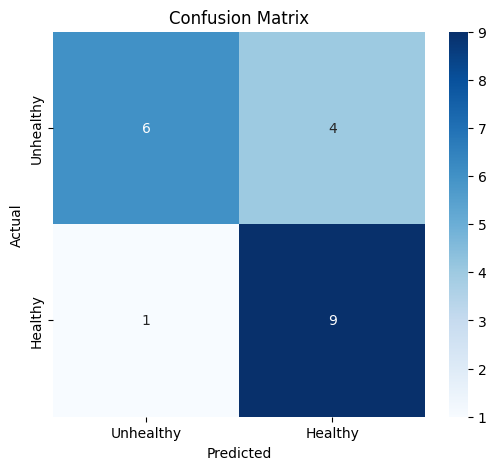

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7500


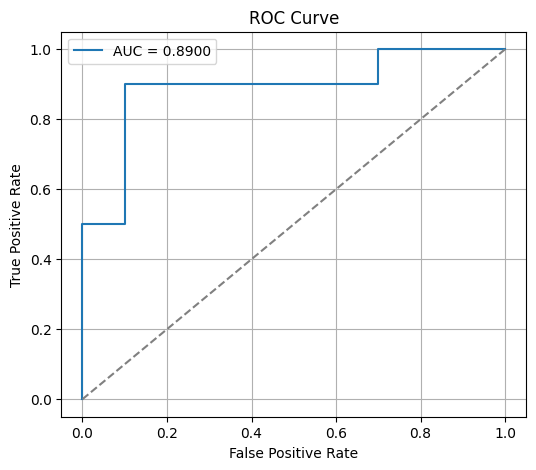

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()